In [1]:
import os
import pandas as pd
import geopandas as gpd
import cdsapi
from datetime import datetime, timedelta
import xarray as xr
import netCDF4
import zipfile
import shutil
import matplotlib.pyplot as plt
from timezonefinder import TimezoneFinder
import pytz
from concurrent.futures import ThreadPoolExecutor, as_completed

# === SETTINGS ===
outage_file  = "data_collection_by_hollis/correlated_outage/extreme_outage_events.csv"
weather_dir  = "data_collection_by_hollis/correlated_outage/weather_output"
os.makedirs(weather_dir , exist_ok=True)

# Load outage events
df = pd.read_csv(outage_file)
print("Rows in outtage data: ", len(df))

Rows in outtage data:  427493


In [2]:
df = df.drop(columns=[
    col for col in df.columns if any(x in col for x in ["STATEFP", "COUNTYFP", "STATE_NAME", "NAME", "lat", "lon"])
])

# Load U.S. county shapefile from Census
shapefile_path = "data_collection_by_hollis/shapefiles/cb_2020_us_county_5m.zip"
counties = gpd.read_file(shapefile_path)
# counties["lat"] = counties.geometry.centroid.y
# counties["lon"] = counties.geometry.centroid.x

# # Re-project to a U.S.-appropriate planar CRS
# counties = counties.to_crs(epsg=5070)
# counties["county_lat"] = counties.geometry.centroid.to_crs(epsg=4326).y
# counties["county_lon"] = counties.geometry.centroid.to_crs(epsg=4326).x
# Re-project to U.S.-appropriate CRS
counties = counties.to_crs(epsg=5070)

# Then compute lat/lon from reprojected centroids
centroids = counties.geometry.centroid.to_crs(epsg=4326)
counties["county_lat"] = centroids.y
counties["county_lon"] = centroids.x

# Rename to match clean merge keys
counties = counties.rename(columns={
    "NAME": "county",
    "STATE_NAME": "state"
})
counties = counties.drop_duplicates(subset=["state", "county"])

df["state"] = df["state"].str.strip().str.lower()
df["county"] = df["county"].str.strip().str.lower()
counties["state"] = counties["state"].str.strip().str.lower()
counties["county"] = counties["county"].str.strip().str.lower()

# Merge on lowercase standardized fields
df = df.merge(
    counties[["state", "county", "county_lat", "county_lon"]],
    on=["state", "county"],
    how="left"
)
print("Rows after merge:", len(df))
counties[['state', 'county', 'county_lat', 'county_lon']].to_csv("county_centroids.csv", index=False)

# Manually assign coordinates for Fairfax city, VA
fairfax_city_idx = (df['state'] == 'virginia') & (df['county'] == 'fairfax city')

# Approximate centroid (based on Google Maps)
df.loc[fairfax_city_idx, 'county_lat'] = 38.8462
df.loc[fairfax_city_idx, 'county_lon'] = -77.3064

df = df.reset_index(drop=True)

missing = df['county_lat'].isna().sum()
# print(df['county_lat'].isna())
print(f"❓ Missing county_lat values: {df['county_lat'].isna().sum()} out of {len(df)}")

df[df['county_lat'].isna()][['state', 'county']].drop_duplicates().to_csv("unmatched_counties.csv", index=False)



Rows after merge: 427493
❓ Missing county_lat values: 0 out of 427493


In [3]:
def unzip_and_collect(zip_path):
    folder = os.path.dirname(zip_path)
    if not zipfile.is_zipfile(zip_path):
        return [zip_path]  # already .nc or uncompressed

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(folder)
        extracted = [os.path.join(folder, f) for f in zip_ref.namelist()]
    return [f for f in extracted if f.endswith(".nc") or f.endswith(".grib")]

In [4]:
def clean_downloaded_nc_files(keep_path, extra_paths):
    for path in extra_paths:
        if os.path.exists(path) and path != keep_path:
            try:
                os.remove(path)
                print(f"🗑️ Deleted extra file: {path}")
            except Exception as e:
                print(f"⚠️ Could not delete: {path}\n   {e}")


In [14]:
import gc

def download_hourly_weather_test(lat, lon, datetime_str, event_index, save_folder):
    import os, cdsapi, pytz, xarray as xr
    from timezonefinder import TimezoneFinder
    import pandas as pd
    from datetime import timedelta

    tf = TimezoneFinder()
    tz_name = tf.timezone_at(lat=lat, lng=lon)
    tz = pytz.timezone(tz_name)
    target_datetime_local = pd.to_datetime(datetime_str)
    target_datetime = tz.localize(target_datetime_local).astimezone(pytz.utc)
    start_datetime = target_datetime - timedelta(hours=47)

    final_file = os.path.join(
        save_folder,
        f"event_{event_index}_{target_datetime.strftime('%Y-%m-%d_%H-%M')}.nc"
    )
    if os.path.exists(final_file):
        print(f"✅ Final 48-hour file already exists, skipping event {event_index}: {final_file}")
        return final_file

    lat = round(float(lat), 4)
    lon = round(float(lon), 4)
    area = [lat, lon, lat, lon]  # Single grid point

    variables_by_step_type = {
        'instant': [
            '2m_temperature', '2m_dewpoint_temperature', 'surface_pressure',
            '10m_u_component_of_wind', '10m_v_component_of_wind',
            'instantaneous_10m_wind_gust', 'total_column_rain_water',
            'boundary_layer_height'
        ],
        'accum': [
            'total_precipitation', 'snowfall',
            'surface_latent_heat_flux', 'surface_net_solar_radiation'
        ],
    }

    def fetch_block(step_type, variables, out_file):
        client = cdsapi.Client()
        try:
            print(f"\n📦 Requesting {step_type} block: {out_file}")
            client.retrieve(
                'reanalysis-era5-single-levels',
                {
                    'product_type': 'reanalysis',
                    'format': 'netcdf',
                    'variable': variables,
                    'year': start_datetime.year,
                    'month': start_datetime.month,
                    'day': list({start_datetime.day, (start_datetime + timedelta(days=1)).day}),
                    'time': [f"{h:02}:00" for h in range(24)],
                    'area': area,
                },
                out_file
            )
            return xr.open_dataset(out_file).load()
        except Exception as e:
            print(f"❌ Failed to fetch 48h block for event {event_index}: {e}")
            return None

    instant_file = os.path.join(save_folder, f"event_{event_index}_instant.nc")
    accum_file = os.path.join(save_folder, f"event_{event_index}_accum.nc")

    ds_instant = fetch_block('instant', variables_by_step_type['instant'], instant_file)
    ds_accum = fetch_block('accum', variables_by_step_type['accum'], accum_file)

    datasets = [ds for ds in [ds_instant, ds_accum] if ds is not None]
    if datasets:
        time_dim = 'time' if 'time' in datasets[0].dims else 'valid_time'
        merged = xr.merge(datasets)
        merged = merged.sortby(time_dim)
        unique_times = ~merged[time_dim].to_index().duplicated()
        merged = merged.isel({time_dim: unique_times})

        final = merged.sel({
            time_dim: slice(
                start_datetime.replace(tzinfo=None),
                target_datetime.replace(tzinfo=None)
            )
        })
        final.to_netcdf(final_file)
        print(f"✅ Saved 48-hour data: {final_file}")

        # 🔄 Release all dataset file handles before cleanup
        for ds in datasets:
            ds.close()
        
        gc.collect()

        # 🧹 Delete temporary files
        for f in [instant_file, accum_file]:
            try:
                os.remove(f)
                print(f"🗑 Deleted temp file: {f}")
            except Exception as e:
                print(f"⚠ Could not delete {f}: {e}")

        return final_file

    print(f"❌ No valid datasets found for event {event_index}")
    return None


In [15]:
i = 426001
row = df.loc[i]

start_time_floor = pd.to_datetime(row['start_time']).floor("h")

lat, lon = row['county_lat'], row['county_lon']
download_hourly_weather_test(lat, lon, start_time_floor, i, 'data_collection_by_hollis/correlated_outage/weather_output')


2025-05-08 12:52:50,357 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-05-08 12:52:50,358 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.



📦 Requesting instant block: data_collection_by_hollis/correlated_outage/weather_output\event_426001_instant.nc


2025-05-08 12:52:51,203 INFO Request ID is 485d6ebb-eef2-4d7d-be89-a14d88b9ad4b
2025-05-08 12:52:51,392 INFO status has been updated to accepted
2025-05-08 12:55:44,943 INFO status has been updated to running
2025-05-08 12:57:11,955 INFO status has been updated to successful


cb03236cbffec077ea0097615aedd0a6.nc:   0%|          | 0.00/88.2k [00:00<?, ?B/s]

2025-05-08 12:57:14,237 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-05-08 12:57:14,238 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.



📦 Requesting accum block: data_collection_by_hollis/correlated_outage/weather_output\event_426001_accum.nc


2025-05-08 12:57:15,155 INFO Request ID is 10801a03-72b7-4328-b2c3-1a03d38e59ee
2025-05-08 12:57:15,368 INFO status has been updated to accepted
2025-05-08 12:58:31,905 INFO status has been updated to successful


d4af667e2c5449ee27513cbafa3a5f36.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_426001_2023-07-29_03-00.nc
🗑 Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_426001_instant.nc
🗑 Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_426001_accum.nc


'data_collection_by_hollis/correlated_outage/weather_output\\event_426001_2023-07-29_03-00.nc'

b'\x89HDF\r\n\x1a\n\x02\x08\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xff\xff\xff\xff\xff\xff\xff\xa7\xed\x01\x00\x00\x00\x00\x000\x00\x00\x00\x00\x00\x00\x00,\x1a*\x9bOHDR\x02\r\xb9\x02\x02"\x00\x00\x00\x00\x00\x03\x14\x00\x00\x00\x00\x00\x00\x00\xa6\xa8\x00\x00\x00\x00\x00\x008\xa9\x00\x00\x00\x00\x00\x00^\xa9\x00\x00\x00\x00\x00\x00\n\x02\x00\x01\x00\x00\x00\x00\x10\x10\x00\x00\x00\x00\x01\x04\x00\x00\x00\x00\x00\x00\x7f\x00\x00\x00\x00\x00\x00\x00\x0c%\x00\x00\x00\x00\x03\x00\x0c\x00\x08\x00\x04\x00\x00GRIB_centre\x00\x13\x00\x00\x00\x04\x00\x00\x00\x02\x00\x00\x00ecmf\x0c^\x00\x00\x01\x00\x03\x00\x17\x00\x08\x00\x04\x00\x00GRIB_centreDescription\x00\x13\x00\x00\x002\x00\x00\x00\x02\x00\x00\x00European Centre for Medium-Range Weather Forecasts\x0c@\x00\x00\x02\x00\x03\x00\x0f\x00\x0c\x00\x14\x00\x00GRIB_subCentre\x00\x10'
data_collection_by_hollis/correlated_outage/weather_output/event_426000_2023-07-29_01-00.nc size: 126375 bytes
1.7.2
{'netcdf4': <NetCDF4BackendEntrypoint>
  Op

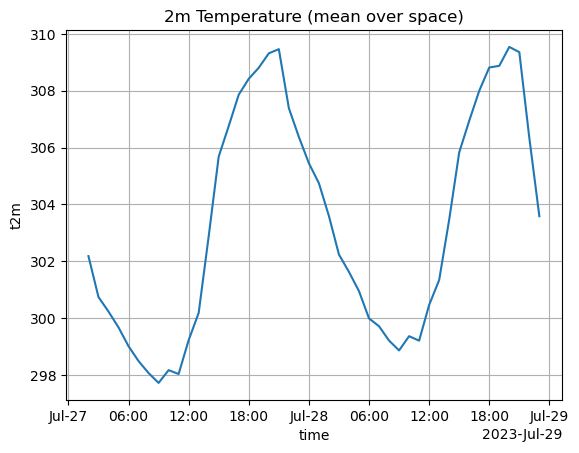

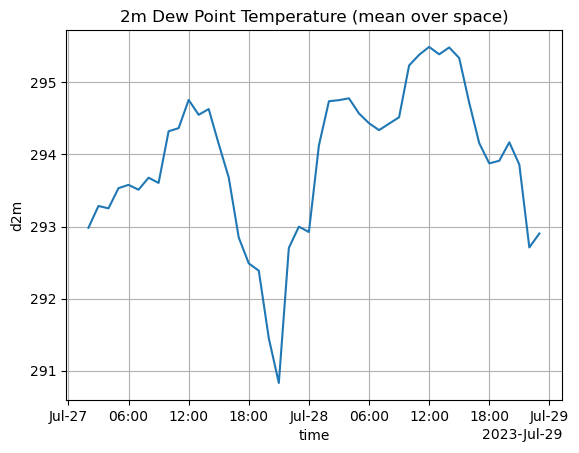

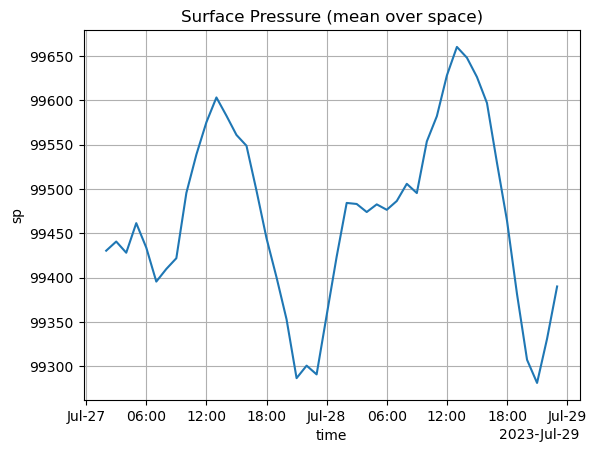

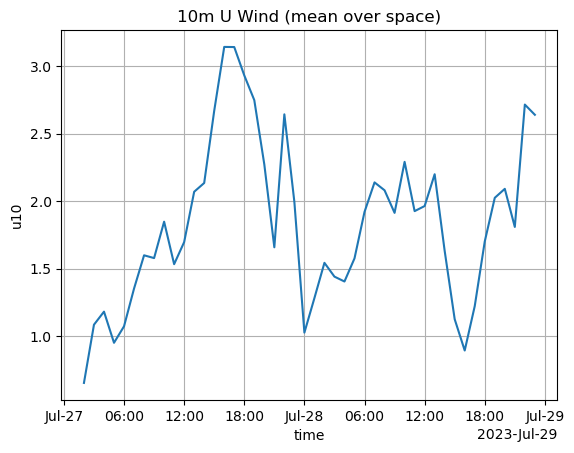

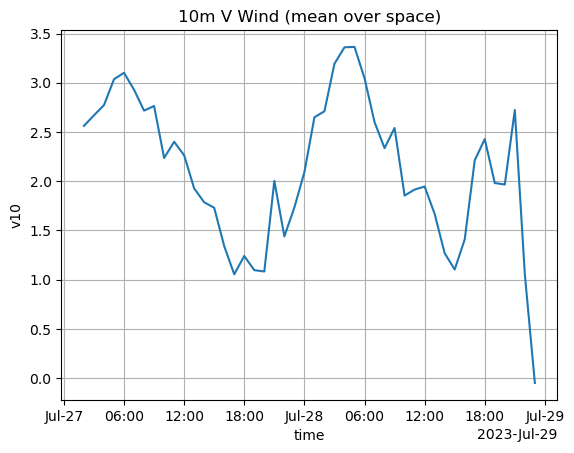

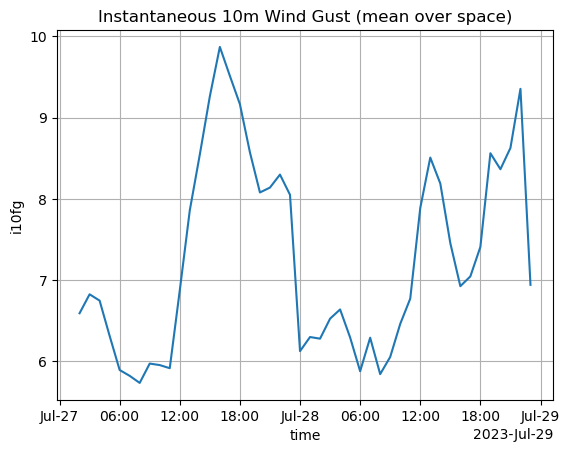

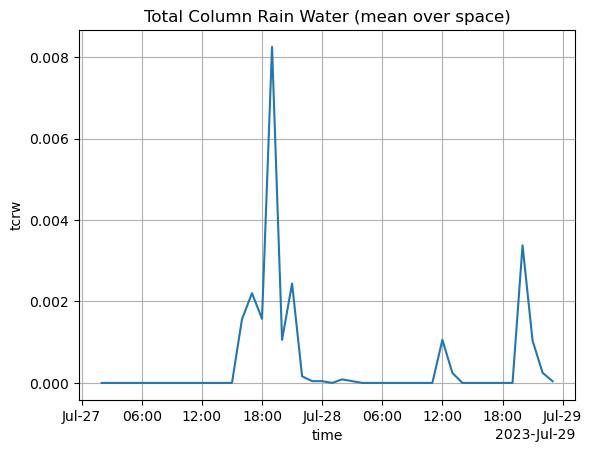

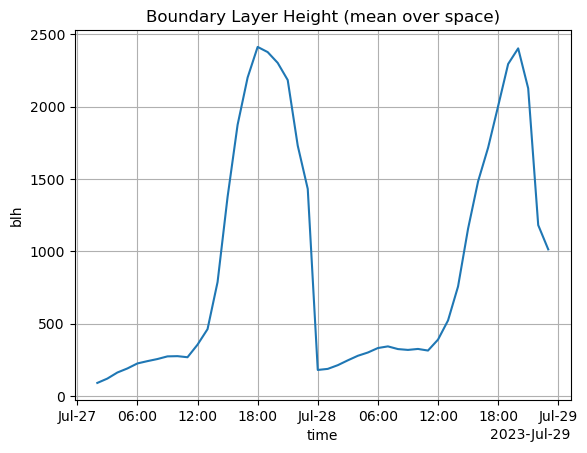

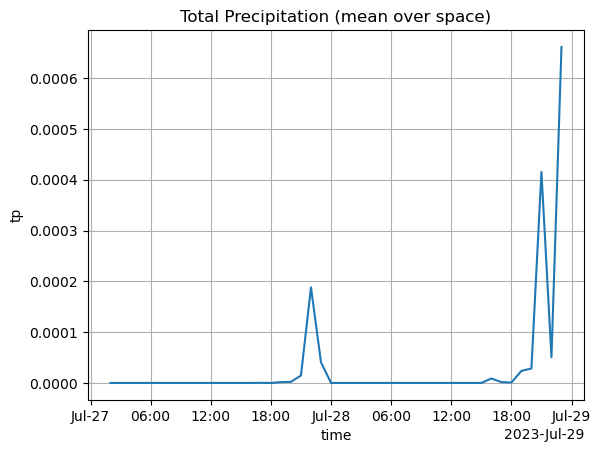

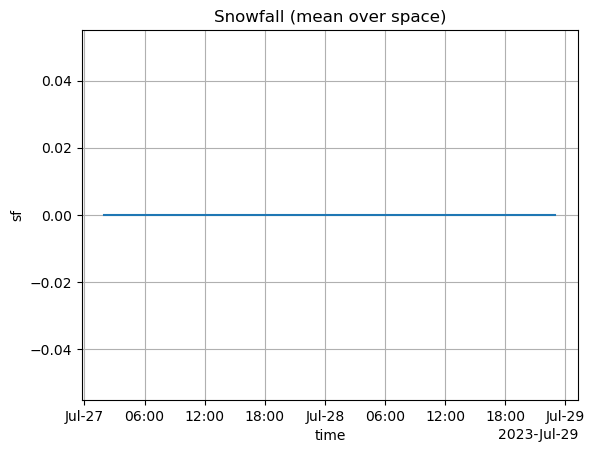

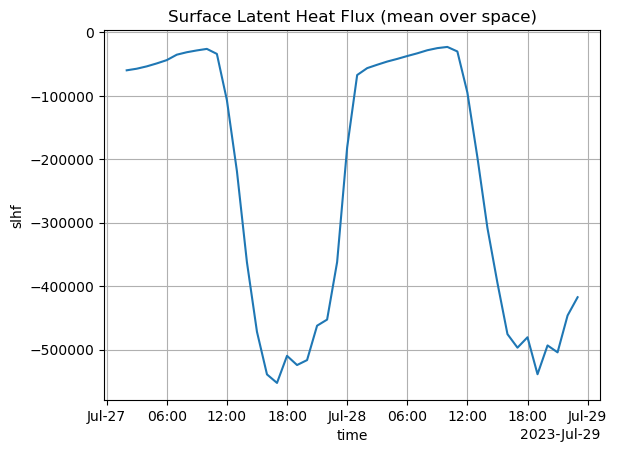

In [13]:

file = "data_collection_by_hollis/correlated_outage/weather_output/event_426000_2023-07-29_01-00.nc"
xr.open_dataset(file, engine="h5netcdf")

with open(file, "rb") as f:
    head = f.read(512)
    print(head[:300])

file_path = file
print(f"{file_path} size: {os.path.getsize(file_path)} bytes")

print(netCDF4.__version__)
print(xr.backends.list_engines())

ds = xr.open_dataset(
    file,
    engine="netcdf4"
)

print(ds)

# Dictionary of variable names and titles
plot_vars = {
    't2m': '2m Temperature',
    'd2m': '2m Dew Point Temperature',
    'sp': 'Surface Pressure',
    'u10': '10m U Wind',
    'v10': '10m V Wind',
    'i10fg': 'Instantaneous 10m Wind Gust',
    'tcrw': 'Total Column Rain Water',
    'blh': 'Boundary Layer Height',
    'tp': 'Total Precipitation',
    'sf': 'Snowfall',
    'slhf': 'Surface Latent Heat Flux',
    'avg_snswrf': 'Average Net Short-Wave Radiation Flux'
}

for var, title in plot_vars.items():
    if var in ds:
        plt.figure()
        ds[var].mean(dim=['latitude', 'longitude']).plot()
        plt.title(f"{title} (mean over space)")
        plt.grid(True)
    else:
        print(f"⚠️ Variable '{var}' not found in dataset.")
ds.close()


In [6]:
def download_hourly_weather(lat, lon, datetime_str, event_index, save_folder):
    tf = TimezoneFinder()
    tz_name = tf.timezone_at(lat=lat, lng=lon)
    tz = pytz.timezone(tz_name)
    target_datetime_local = pd.to_datetime(datetime_str)
    target_datetime = tz.localize(target_datetime_local).astimezone(pytz.utc)
    start_datetime = target_datetime - timedelta(hours=47)

    # 🔥 FINAL file path for event (create immediately)
    final_file = os.path.join(
        save_folder,
        f"event_{event_index}_{target_datetime.strftime('%Y-%m-%d_%H-%M')}.nc"
    )

    # 🔥 EARLY EXIT if final file already exists
    if os.path.exists(final_file):
        print(f"✅ Final 48-hour file already exists, skipping event {event_index}: {final_file}")
        return final_file

    # area = [round(float(lat)+0.1, 4), round(float(lon)-0.1, 4),
    #         round(float(lat)-0.1, 4), round(float(lon)+0.1, 4)]
    lat = round(float(lat), 4)
    lon = round(float(lon), 4)
    area = [lat, lon, lat, lon]  # Single point — not a box 

    variables_by_type = {
        'instant': [
            '2m_temperature', '2m_dewpoint_temperature', 'surface_pressure',
            '10m_u_component_of_wind', '10m_v_component_of_wind',
            'instantaneous_10m_wind_gust', 'total_column_rain_water',
            'boundary_layer_height'
        ],
        'accum': [
            'total_precipitation', 'snowfall',
            'surface_latent_heat_flux', 'surface_net_solar_radiation'
        ],
    }

    temp_files = []

    def fetch_and_open(day, offset, var_list, step_type):
        year, month, day_val = day.year, day.month, day.day
        tag = f"event_{event_index}{day.strftime('%Y-%m-%d')}_D-{offset}{step_type}.nc"
        out_path = os.path.join(save_folder, tag)

        if not os.path.exists(out_path):
            print(f"\n📦 Downloading: {out_path}")
            client = cdsapi.Client()
            client.retrieve(
                'reanalysis-era5-single-levels',
                {
                    'product_type': 'reanalysis',
                    'format': 'netcdf',
                    'variable': var_list,
                    'year': year,
                    'month': month,
                    'day': day_val,
                    'time': [f"{h:02}:00" for h in range(24)],
                    'area': area,
                },
                out_path
            )
        else:
            print(f"📦 Already downloaded: {out_path}")

        temp_files.append(out_path)
        return xr.open_dataset(out_path)

    all_datasets = []

    for offset in [2, 1, 0]:
        date = target_datetime.date() - timedelta(days=offset)
        for step_type, vars in variables_by_type.items():
            try:
                ds = fetch_and_open(date, offset, vars, step_type)
                all_datasets.append(ds.load())
                ds.close()
            except Exception as e:
                print(f"⚠ Failed to fetch or load for {date} {step_type}: {e}")

    if all_datasets:
        time_dim = 'time' if 'time' in all_datasets[0].dims else 'valid_time'
        merged = xr.merge(all_datasets)
        merged = merged.sortby(time_dim)
        unique_times = ~merged[time_dim].to_index().duplicated()
        merged = merged.isel({time_dim: unique_times})

        final = merged.sel({
            time_dim: slice(
                start_datetime.replace(tzinfo=None),
                target_datetime.replace(tzinfo=None)
            )
        })

        final.to_netcdf(final_file)
        print(f"✅ Saved 48-hour data: {final_file}")

        # 🧹 Clean up temporary downloaded files
        for f in temp_files:
            try:
                os.remove(f)
                print(f"🗑 Deleted temp file: {f}")
            except Exception as e:
                print(f"⚠ Could not delete {f}: {e}")

        return final_file

    print(f"❌ No valid datasets found for event {event_index}")
    return None

In [7]:
# NEED TO CONVERT TO UTC
df = df.reset_index(drop=True)

for i, row in df.iterrows():
    # print(i)
    try:
        if pd.isnull(row['start_time']):
            continue
        # ⏱️ Round down to nearest hour
        start_time_floor = pd.to_datetime(row['start_time']).floor("h")

        lat, lon = row['county_lat'], row['county_lon']
        download_hourly_weather(lat, lon, start_time_floor, i, 'data_collection_by_hollis/correlated_outage/weather_output')

    except Exception as e:
        print(f"❌ Failed event {i} ({row['county']}): {e}")
    break


✅ Final 48-hour file already exists, skipping event 0: data_collection_by_hollis/correlated_outage/weather_output\event_0_2014-11-24_15-00.nc


In [18]:
# df = df.reset_index(drop=True)
# print(df.shape)
# print(df.head(3))
# print(df.index)
event_indcies = [i for i in reversed(df.index) if i < 426489]
# for i in reversed(df.index):
for i in event_indcies:
    row = df.loc[i]
    #print(i)
    try:
        if pd.isnull(row['start_time']):
            continue
        # ⏱️ Round down to nearest hour
        start_time_floor = pd.to_datetime(row['start_time']).floor("h")

        lat, lon = row['county_lat'], row['county_lon']
        download_hourly_weather_test(lat, lon, start_time_floor, i, 'data_collection_by_hollis/correlated_outage/weather_output')

    except Exception as e:
        print(f"❌ Failed event {i} ({row['county']}): {e}")
    #break

✅ Final 48-hour file already exists, skipping event 426488: data_collection_by_hollis/correlated_outage/weather_output\event_426488_2023-03-04_07-00.nc
✅ Final 48-hour file already exists, skipping event 426487: data_collection_by_hollis/correlated_outage/weather_output\event_426487_2023-03-04_01-00.nc


2025-05-08 13:01:19,635 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-05-08 13:01:19,642 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.



📦 Requesting instant block: data_collection_by_hollis/correlated_outage/weather_output\event_426486_instant.nc


2025-05-08 13:01:20,791 INFO Request ID is 540d493c-9432-4cdc-bb20-b06541d8c982
2025-05-08 13:01:20,979 INFO status has been updated to accepted
2025-05-08 13:04:14,361 INFO status has been updated to successful


c7b0a5299cbe80184eaba5568f5df2d5.nc:   0%|          | 0.00/88.3k [00:00<?, ?B/s]

2025-05-08 13:04:16,715 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-05-08 13:04:16,715 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.



📦 Requesting accum block: data_collection_by_hollis/correlated_outage/weather_output\event_426486_accum.nc


2025-05-08 13:04:17,414 INFO Request ID is adc305f1-e449-4ab8-813e-12e4853cc6d8
2025-05-08 13:04:17,650 INFO status has been updated to accepted
2025-05-08 13:05:34,393 INFO status has been updated to running
2025-05-08 13:07:11,389 INFO status has been updated to successful


657e3cac66b2610937c564e5df299e0f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_426486_2023-03-05_00-00.nc
🗑 Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_426486_instant.nc
🗑 Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_426486_accum.nc


2025-05-08 13:07:19,224 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-05-08 13:07:19,225 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.



📦 Requesting instant block: data_collection_by_hollis/correlated_outage/weather_output\event_426485_instant.nc


2025-05-08 13:07:20,279 INFO Request ID is 01487698-c991-42c2-af7d-7a9f06b1774c
2025-05-08 13:07:20,468 INFO status has been updated to accepted


KeyboardInterrupt: 

In [ ]:

def process_event(i):
    row = df.loc[i]
    try:
        if pd.isnull(row['start_time']):
            return f"⏭️ Skipped null start_time at event {i}"

        start_time_floor = pd.to_datetime(row['start_time']).floor("h")
        lat, lon = row['county_lat'], row['county_lon']

        download_hourly_weather(lat, lon, start_time_floor, i, 'data_collection_by_hollis/correlated_outage/weather_output')
        return f"✅ Finished event {i}"

    except Exception as e:
        return f"❌ Failed event {i} ({row.get('county', 'Unknown')}): {e}"

# 🔁 Reversed index list
# event_indices = list(reversed(df.index))
event_indcies = [i for i in reversed(df.index) if i < 426489]

# ⚡ Threaded execution
max_workers = 4  # You can increase to 6–8 if your system handles it well
with ThreadPoolExecutor(max_workers=max_workers) as executor:
    
    futures = [executor.submit(process_event, i) for i in event_indcies]

    for future in as_completed(futures):
        print(future.result())
        break


✅ Final 48-hour file already exists, skipping event 426586: data_collection_by_hollis/correlated_outage/weather_output\event_426586_2023-04-03_16-00.nc
✅ Finished event 426586
✅ Final 48-hour file already exists, skipping event 426589: data_collection_by_hollis/correlated_outage/weather_output\event_426589_2023-04-01_22-00.nc
✅ Final 48-hour file already exists, skipping event 426587: data_collection_by_hollis/correlated_outage/weather_output\event_426587_2023-04-06_04-00.nc
✅ Final 48-hour file already exists, skipping event 426588: data_collection_by_hollis/correlated_outage/weather_output\event_426588_2023-04-06_05-00.nc
✅ Final 48-hour file already exists, skipping event 426584: data_collection_by_hollis/correlated_outage/weather_output\event_426584_2023-04-01_20-00.nc
✅ Final 48-hour file already exists, skipping event 426582: data_collection_by_hollis/correlated_outage/weather_output\event_426582_2023-04-02_00-00.nc
✅ Final 48-hour file already exists, skipping event 426583: data

In [ ]:
def process_event(i):
    row = df.loc[i]
    try:
        if pd.isnull(row['start_time']):
            return f"⏭️ Skipped null start_time at event {i}"

        start_time_floor = pd.to_datetime(row['start_time']).floor("h")
        lat, lon = row['county_lat'], row['county_lon']

        download_hourly_weather(lat, lon, start_time_floor, i, 'data_collection_by_hollis/correlated_outage/weather_output')
        return f"✅ Finished event {i}"

    except Exception as e:
        return f"❌ Failed event {i} ({row.get('county', 'Unknown')}): {e}"

# 🔁 Reversed index list
# event_indices = list((df.index))
event_indices = [i for i in df.index if i > 5060]

# ⚡ Threaded execution
max_workers = 4  # You can increase to 6–8 if your system handles it well
with ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = [executor.submit(process_event, i) for i in event_indices]

    for future in as_completed(futures):
        print(future.result())

b'\x89HDF\r\n\x1a\n\x02\x08\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xff\xff\xff\xff\xff\xff\xff\xe6\xed\x01\x00\x00\x00\x00\x000\x00\x00\x00\x00\x00\x00\x00I\x99\xa5EOHDR\x02\r\xb9\x02\x02"\x00\x00\x00\x00\x00\x03\x14\x00\x00\x00\x00\x00\x00\x00\xa6\xa8\x00\x00\x00\x00\x00\x008\xa9\x00\x00\x00\x00\x00\x00^\xa9\x00\x00\x00\x00\x00\x00\n\x02\x00\x01\x00\x00\x00\x00\x10\x10\x00\x00\x00\x00\x01\x04\x00\x00\x00\x00\x00\x00\x7f\x00\x00\x00\x00\x00\x00\x00\x0c%\x00\x00\x00\x00\x03\x00\x0c\x00\x08\x00\x04\x00\x00GRIB_centre\x00\x13\x00\x00\x00\x04\x00\x00\x00\x02\x00\x00\x00ecmf\x0c^\x00\x00\x01\x00\x03\x00\x17\x00\x08\x00\x04\x00\x00GRIB_centreDescription\x00\x13\x00\x00\x002\x00\x00\x00\x02\x00\x00\x00European Centre for Medium-Range Weather Forecasts\x0c@\x00\x00\x02\x00\x03\x00\x0f\x00\x0c\x00\x14\x00\x00GRIB_subCentre\x00\x10'
data_collection_by_hollis/correlated_outage/weather_output/event_426486_2023-03-05_00-00.nc size: 126438 bytes
1.7.2
{'netcdf4': <NetCDF4BackendEntrypoint>
  Op

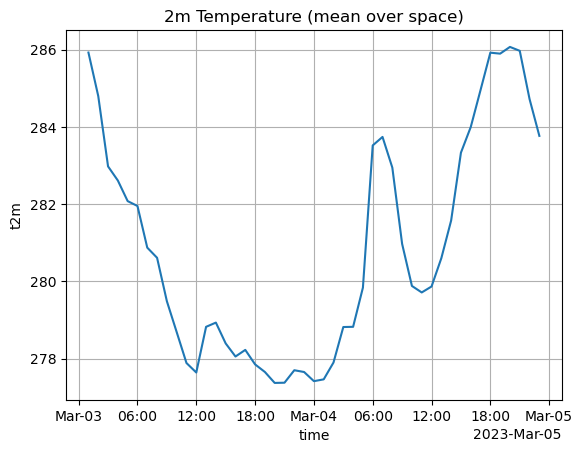

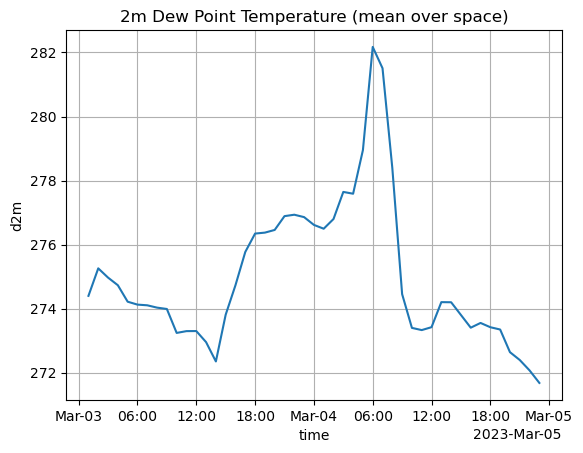

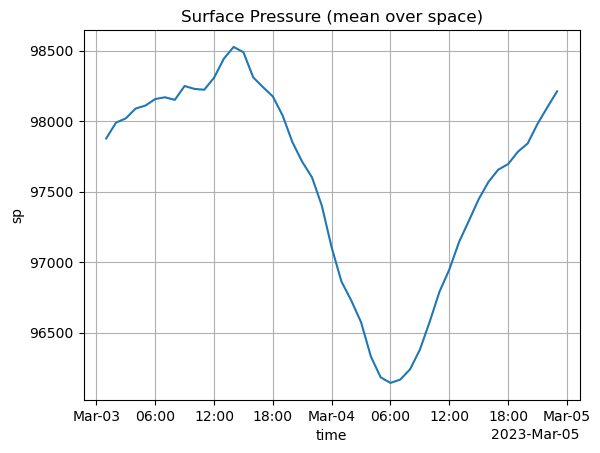

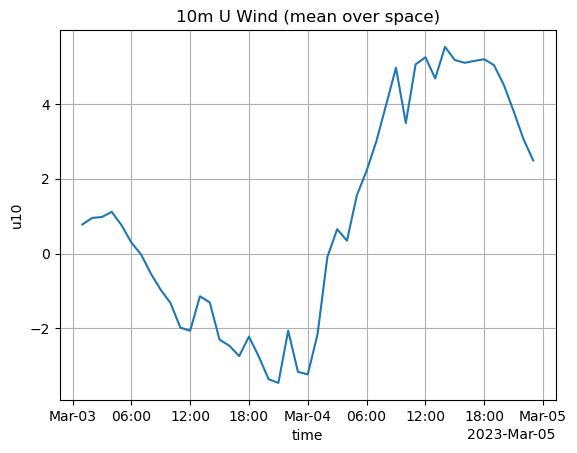

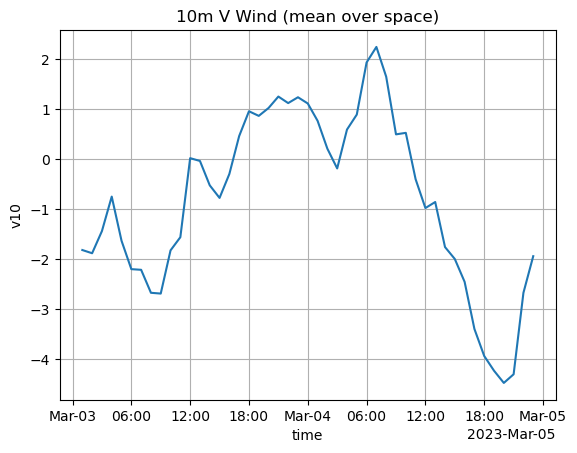

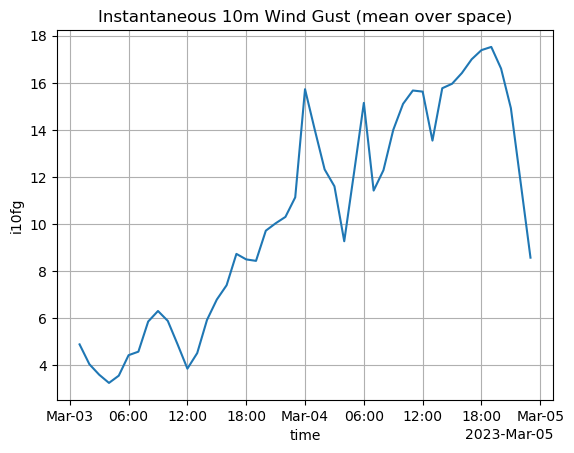

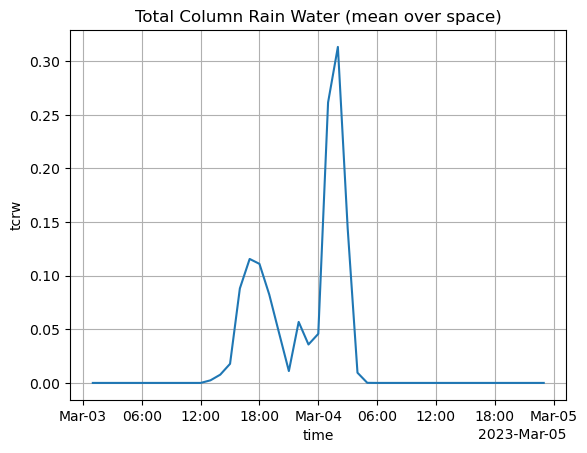

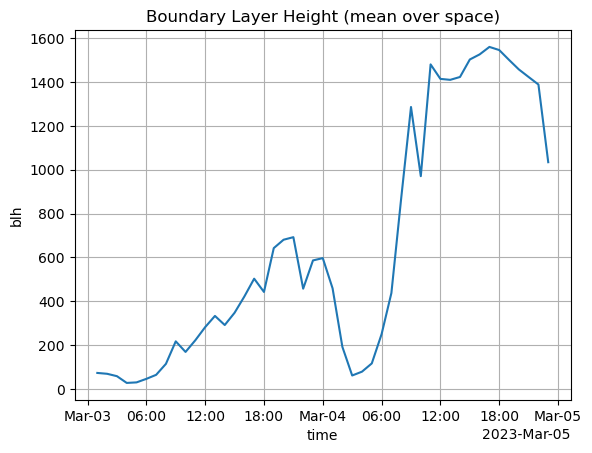

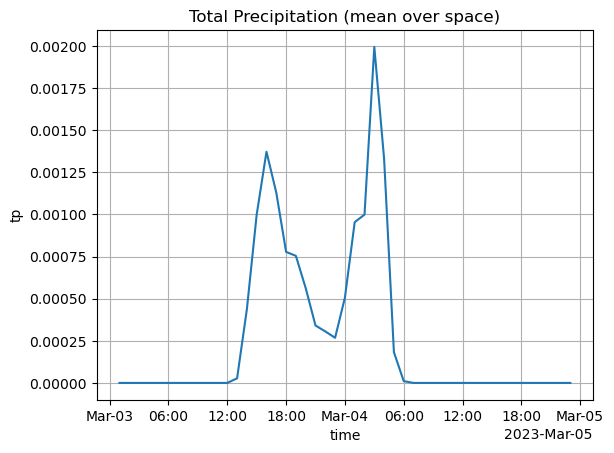

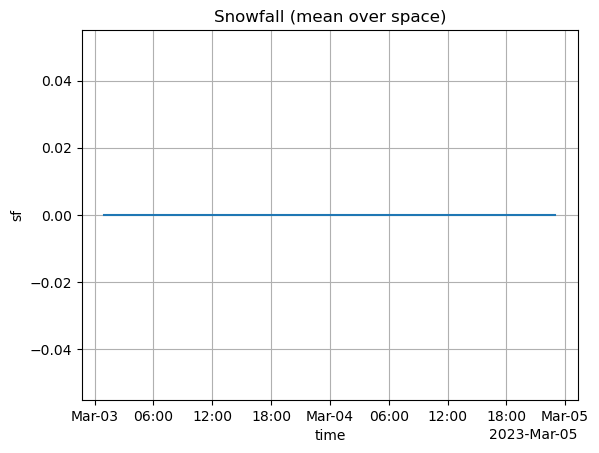

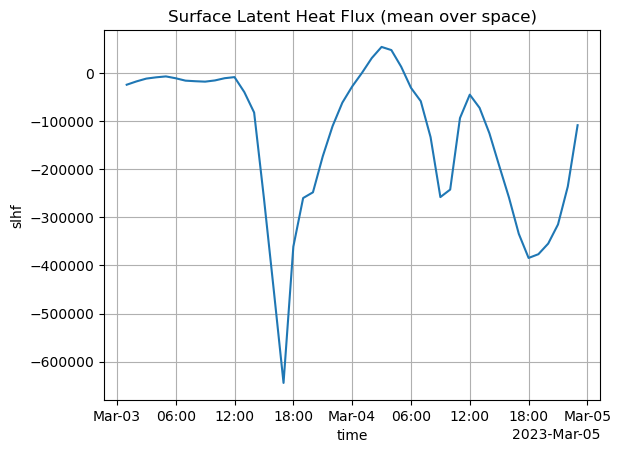

In [19]:
import matplotlib.pyplot as plt

file = "data_collection_by_hollis/correlated_outage/weather_output/event_426486_2023-03-05_00-00.nc"
#file = "data_collection_by_hollis/correlated_outage/weather_output/event_4359872023-07-3023-00.nc"
xr.open_dataset(file, engine="h5netcdf")

with open(file, "rb") as f:
    head = f.read(512)
    print(head[:300])

file_path = file
print(f"{file_path} size: {os.path.getsize(file_path)} bytes")

print(netCDF4.__version__)
print(xr.backends.list_engines())

ds = xr.open_dataset(
    file,
    engine="netcdf4"
)

print(ds)

# Dictionary of variable names and titles
plot_vars = {
    't2m': '2m Temperature',
    'd2m': '2m Dew Point Temperature',
    'sp': 'Surface Pressure',
    'u10': '10m U Wind',
    'v10': '10m V Wind',
    'i10fg': 'Instantaneous 10m Wind Gust',
    'tcrw': 'Total Column Rain Water',
    'blh': 'Boundary Layer Height',
    'tp': 'Total Precipitation',
    'sf': 'Snowfall',
    'slhf': 'Surface Latent Heat Flux',
    'avg_snswrf': 'Average Net Short-Wave Radiation Flux'
}

for var, title in plot_vars.items():
    if var in ds:
        plt.figure()
        ds[var].mean(dim=['latitude', 'longitude']).plot()
        plt.title(f"{title} (mean over space)")
        plt.grid(True)
    else:
        print(f"⚠️ Variable '{var}' not found in dataset.")
ds.close()


In [ ]:
with open(file_path, "rb") as f:
    magic = f.read(4)
    print("Magic bytes:", magic)

print(ds)
print(ds.variables)
print(ds.attrs) 

Magic bytes: b'\x89HDF'
<xarray.Dataset> Size: 1kB
Dimensions:     (valid_time: 48, latitude: 1, longitude: 1)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 384B 2014-11-22T16:00:00 ... 2014...
  * latitude    (latitude) float64 8B 36.27
  * longitude   (longitude) float64 8B -90.52
    expver      (valid_time) <U4 768B ...
Data variables:
    tp          (valid_time, latitude, longitude) float32 192B 0.0 ... 0.0
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-24T02:44 GRIB to CDM+CF via cfgrib-0.9.1...
Frozen({'tp': <xarray.Variable (valid_time: 48, latitude: 1, longitude: 1)> Size: 192B
array([[[0.000000e+00]],

       [[1.510022e-05]],

       [[0.000000e+00]],

       [[0.000000e+00]],